# Обучение char-level языковой модели с помощью RNN

Установим модуль datasets, чтобы нам проще было работать с данными

In [1]:
!pip install datasets

Импорт необходимых библиотек

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import sent_tokenize
from sklearn.model_selection import train_test_split
import nltk

from collections import Counter
from typing import List

import seaborn
seaborn.set(palette='summer')

In [3]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/andrey/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

## Подготовка данных

Библиотека datasets позволяет кэшировать преобразования над данными.

In [5]:
# Загрузим датасет
dataset = load_dataset('IlyaGusev/gazeta', revision="v1.0")

### Структура датасета

Датасет представляет собой набор текстов

In [6]:
dataset['validation']

Dataset({
    features: ['text', 'summary', 'title', 'date', 'url'],
    num_rows: 5265
})

In [7]:
val_len = len(dataset['validation']['text'])
print(f"len = {val_len}")
idx = np.random.choice(val_len)
print(f"idx = {idx}")

print(f"title: {dataset['validation']['title'][idx]}")
print(f"date: {dataset['validation']['date'][idx]}")
print(f"summary: {dataset['validation']['summary'][idx]}")
print(f"url: {dataset['validation']['url'][idx]}")
dataset['validation']['text'][idx]

len = 5265
idx = 3391
title: Смотрите внимательно: россиян научили выбирать алкоголь
date: 2019-06-23 13:57:33
summary: Роспотребнадзор сделал рекомендации по выбору качественного алкоголя. Документ с пожеланиями для потребителей опубликован на сайте ведомства. Покупать алкогольные изделия можно только в стационарных магазинах с лицензией и только через кассу.
url: https://www.gazeta.ru/business/2019/06/23/12436345.shtml


'Алкогольную продукцию Роспотребнадзор предлагает покупать в стационарных точках торговли. При этом магазины, торгующие спиртным, должны иметь лицензию. Документы, дающие право торговой точке реализовывать алкоголь, обязаны быть на виду – то есть находиться в доступном для покупателя месте. Кроме того, алкоголь должен быть зарегистрирован в ЕГАИС, поэтому его продажа возможна только через кассу с выдачей чека, уточняют в ведомстве. Роспотребнадзор также напомнил, что продажа алкоголя через интернет запрещена, хотя разговоры о старте продаж спиртосодержащей продукции в сети идут уже давно. На бутылке или упаковке легально продаваемого алкоголя должны быть размещены федеральная марка (для отечественной продукции) и акцизная марка (для импортной). Исключение сделано для пива, пивных напитков, сидра, пуаре и медовухи. «Все хорошо в меру, и чрезмерное употребление алкоголя не только не принесет пользы вашему здоровью, но и нанесет ему непоправимый вред», — напомнили в ведомстве. Ранее иссле

### Разделение на предложения 

1. Делим каждый текст на предложения
2. Берём предложения только менее 128 символов
3. Приводим к нижнему регистру
4. Соединяем все предложения из всех статей в один большой list предложений

In [8]:
sent_tokenize(dataset['validation']['text'][idx], language='russian')[:5]

['Алкогольную продукцию Роспотребнадзор предлагает покупать в стационарных точках торговли.',
 'При этом магазины, торгующие спиртным, должны иметь лицензию.',
 'Документы, дающие право торговой точке реализовывать алкоголь, обязаны быть на виду – то есть находиться в доступном для покупателя месте.',
 'Кроме того, алкоголь должен быть зарегистрирован в ЕГАИС, поэтому его продажа возможна только через кассу с выдачей чека, уточняют в ведомстве.',
 'Роспотребнадзор также напомнил, что продажа алкоголя через интернет запрещена, хотя разговоры о старте продаж спиртосодержащей продукции в сети идут уже давно.']

In [9]:
sentences = []

example_sentences_list = sent_tokenize(dataset['validation']['text'][idx], language='russian')[:5]

sentences.extend([i.lower() for i in example_sentences_list])
sentences

['алкогольную продукцию роспотребнадзор предлагает покупать в стационарных точках торговли.',
 'при этом магазины, торгующие спиртным, должны иметь лицензию.',
 'документы, дающие право торговой точке реализовывать алкоголь, обязаны быть на виду – то есть находиться в доступном для покупателя месте.',
 'кроме того, алкоголь должен быть зарегистрирован в егаис, поэтому его продажа возможна только через кассу с выдачей чека, уточняют в ведомстве.',
 'роспотребнадзор также напомнил, что продажа алкоголя через интернет запрещена, хотя разговоры о старте продаж спиртосодержащей продукции в сети идут уже давно.']

In [10]:
sentences = []

for sentence in tqdm(dataset['validation']['text']):
    sentences.extend(
        [x.lower() for x in sent_tokenize(sentence, language='russian') if len(x) < 128]
        )

  0%|          | 0/5265 [00:00<?, ?it/s]

Число предложений во всех текстах

In [11]:
len(sentences)

122237

Пример предложения

In [12]:
print(sentences[0])
print(len(sentences[0]))

красно-белые, усилив атакующую линию, взялись за укрепление центральной зоны.
77


### Словарь из символов

In [13]:
chars = Counter()

for sentence in tqdm(sentences):
    for char in sentence:
        chars[char] += 1

  0%|          | 0/122237 [00:00<?, ?it/s]

Составляем словарь, не берём символы, которые встречаются менее 500 раз

In [14]:
vocab = set(['<unk>', '<bos>', '<eos>', '<pad>'])
counter_threshold = 500

for char, cnt in chars.items():
    if cnt > counter_threshold:
        vocab.add(char)

In [15]:
len(vocab)

86

In [16]:
vocab

{' ',
 '!',
 '$',
 '%',
 '(',
 ')',
 ',',
 '-',
 '.',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ':',
 '<bos>',
 '<eos>',
 '<pad>',
 '<unk>',
 '?',
 '[',
 ']',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 '«',
 '»',
 'а',
 'б',
 'в',
 'г',
 'д',
 'е',
 'ж',
 'з',
 'и',
 'й',
 'к',
 'л',
 'м',
 'н',
 'о',
 'п',
 'р',
 'с',
 'т',
 'у',
 'ф',
 'х',
 'ц',
 'ч',
 'ш',
 'щ',
 'ъ',
 'ы',
 'ь',
 'э',
 'ю',
 'я',
 '–',
 '—'}

#### Словари в виде dict

In [17]:
char2ind = {char: i for i, char in enumerate(vocab)}
ind2char = {i: char for char, i in char2ind.items()}

### Создаём класс для датасета

In [18]:
class CharDataset:
    def __init__(self, sentences):
        self.data = sentences
        self.unk_id = char2ind['<unk>']
        self.bos_id = char2ind['<bos>']
        self.eos_id = char2ind['<eos>']
        self.pad_id = char2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:
        tokenized_sentence = [self.bos_id]
        tokenized_sentence += [char2ind.get(char, self.unk_id) for char in self.data[idx]]
        tokenized_sentence += [self.eos_id]

        return tokenized_sentence

    def __len__(self) -> int:
        return len(self.data)

In [30]:
def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=char2ind['<pad>']) -> torch.Tensor:
    seq_lens = [len(x) for x in input_batch]
    max_seq_len = max(seq_lens)

    new_batch = []
    for sequence in input_batch:
        # паддинг до самой длинной послдеовательности в батче
        for _ in range(max_seq_len - len(sequence)):
            sequence.append(pad_id)
        new_batch.append(sequence)

    sequences = torch.LongTensor(new_batch).to(device)

    # Токены "target_ids" - это следующие токены относительно "input_ids"
    # То есть
    # target_ids[n_batch, i] = input_ids[n_batch, i+1]
    new_batch = {
        # все токены, не включая последний
        'input_ids': sequences[:,:-1],
        # все токены, смещённые на 1 влево
        'target_ids': sequences[:,1:]
    }

    return new_batch

In [20]:
train_sentences, eval_sentences = train_test_split(sentences, test_size=0.2)

train_dataset = CharDataset(train_sentences)
eval_dataset = CharDataset(eval_sentences)

train_dataloader = DataLoader(
    train_dataset, collate_fn=collate_fn_with_padding, batch_size=256)

eval_dataloader = DataLoader(
    eval_dataset, collate_fn=collate_fn_with_padding, batch_size=256)

In [21]:
text_example = next(iter(train_dataset))
"".join([ind2char[i] for i in text_example])

'<bos>ответным эмбарго возмущалось руководство рпц.<eos>'

In [22]:
np.arange(6)[:-1]

array([0, 1, 2, 3, 4])

### Как выглядит работа DataLoader

In [24]:
input_ids_test = next(iter(train_dataloader))['input_ids']
target_ids_test = next(iter(train_dataloader))['target_ids']

In [26]:
input_ids_test.shape

torch.Size([256, 127])

In [27]:
target_ids_test.shape

torch.Size([256, 127])

In [28]:
input_ids_test

tensor([[ 1, 43, 55,  ..., 71, 71, 71],
        [ 1, 22,  3,  ..., 71, 71, 71],
        [ 1, 34, 37,  ..., 71, 71, 71],
        ...,
        [ 1,  7, 35,  ..., 71, 71, 71],
        [ 1, 66, 19,  ..., 71, 71, 71],
        [ 1, 77,  9,  ..., 71, 71, 71]])

In [29]:
target_ids_test

tensor([[43, 55, 77,  ..., 71, 71, 71],
        [22,  3, 55,  ..., 71, 71, 71],
        [34, 37, 77,  ..., 71, 71, 71],
        ...,
        [ 7, 35, 61,  ..., 71, 71, 71],
        [66, 19, 43,  ..., 71, 71, 71],
        [77,  9, 13,  ..., 71, 71, 71]])

## Архитектура модели

In [36]:
class CharLM(nn.Module):
    def __init__(self, hidden_dim: int, vocab_size: int):
        super().__init__()
        # Эмбеддинг символа - по индексу символа сопоставляет ему вектор
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        # Рекурентный блок
        self.rnn = nn.GRU(hidden_dim, hidden_dim, batch_first=True)
        # Линейный слой
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        # Линейный слой для проекции на словарь
        self.projection = nn.Linear(hidden_dim, vocab_size)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

    def forward(self, input_batch) -> torch.Tensor:
        # Эмбеддинг слова из вектора размерности словаря
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        # output - скрытые состояния RNN слоя для данного слова
        # hidden_dim - размерность скрытого состояния RNN
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]
        # Применяем нелинейную ф-цию и дропаут
        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, seq_len, hidden_dim]
        # Ещё раз нелинейность и проекцию на размерность словаря
        # 
        projection = self.projection(self.non_lin(output))  # [batch_size, seq_len, vocab_size]

        return projection

## Train loop

Функция для рассчёта перплексии (экспонента от кроссэнтропии)

In [37]:
# разворачивает двумерный тензор [batch_size, n_tokens] в одномерный вектор
target_ids_test.flatten()

tensor([43, 55, 77,  ..., 71, 71, 71])

In [38]:
def evaluate(model, criterion) -> float:
    """
    Calculate perplexity on validation dataloader.
    """

    model.eval()
    perplexity = []
    with torch.no_grad():
        for batch in eval_dataloader:
            logits = model(batch['input_ids']).flatten(start_dim=0, end_dim=1)
            loss = criterion(
                logits,
                batch['target_ids'].flatten()
                )
            perplexity.append(torch.exp(loss).item())

    perplexity = sum(perplexity) / len(perplexity)

    return perplexity

In [39]:
model = CharLM(hidden_dim=256, vocab_size=len(vocab)).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=char2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())

### Что модель даёт на выходе

In [41]:
output = model(input_ids_test)
output.shape # [batch_size, seq_len, vocab_size]

torch.Size([256, 127, 86])

In [42]:
output

tensor([[[-0.0867, -0.0847, -0.0420,  ..., -0.0363,  0.0016,  0.0500],
         [-0.1342, -0.0558, -0.1559,  ...,  0.1246,  0.0811,  0.0523],
         [-0.1262, -0.1586, -0.1075,  ..., -0.0428, -0.0049, -0.1219],
         ...,
         [-0.1335,  0.0282, -0.1048,  ..., -0.0780,  0.0658,  0.0276],
         [-0.0608,  0.0513,  0.0601,  ..., -0.1040,  0.0867, -0.0335],
         [-0.1529, -0.0799, -0.0101,  ..., -0.1668,  0.0326,  0.0055]],

        [[-0.0787, -0.0890, -0.0656,  ..., -0.0049,  0.0213,  0.0192],
         [-0.0452,  0.1743, -0.0570,  ...,  0.2021,  0.1029,  0.1145],
         [-0.2376,  0.1443, -0.0393,  ...,  0.0882,  0.0254,  0.0958],
         ...,
         [-0.1431,  0.0066, -0.0131,  ..., -0.1138,  0.1019, -0.0226],
         [-0.1020, -0.0100,  0.0052,  ..., -0.1831,  0.0108, -0.0143],
         [-0.0692,  0.0707, -0.0595,  ..., -0.0490,  0.1431,  0.0488]],

        [[-0.1026, -0.1003, -0.0352,  ...,  0.0104, -0.0145, -0.0181],
         [-0.0858, -0.0141,  0.0124,  ...,  0

In [22]:
num_epoch = 10
losses = []
perplexities = []

for epoch in range(num_epoch):
    epoch_losses = []
    model.train()
    for batch in tqdm(train_dataloader, desc=f'Training epoch {epoch}:'):
        optimizer.zero_grad()
        logits = model(batch['input_ids']).flatten(start_dim=0, end_dim=1)
        loss = criterion(
            logits, batch['target_ids'].flatten())
        loss.backward()
        optimizer.step()

        epoch_losses.append(loss.item())

    losses.append(sum(epoch_losses) / len(epoch_losses))
    perplexities.append(evaluate(model, criterion))

Training epoch 0::   0%|          | 0/382 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/382 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/382 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/382 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/382 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/382 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/382 [00:00<?, ?it/s]

Training epoch 7::   0%|          | 0/382 [00:00<?, ?it/s]

Training epoch 8::   0%|          | 0/382 [00:00<?, ?it/s]

Training epoch 9::   0%|          | 0/382 [00:00<?, ?it/s]

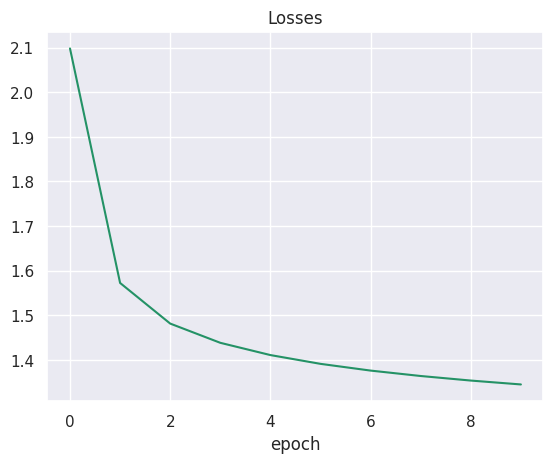

In [23]:
plt.plot(np.arange(len(losses)), losses)
plt.title('Losses')
plt.xlabel("epoch")
plt.show()

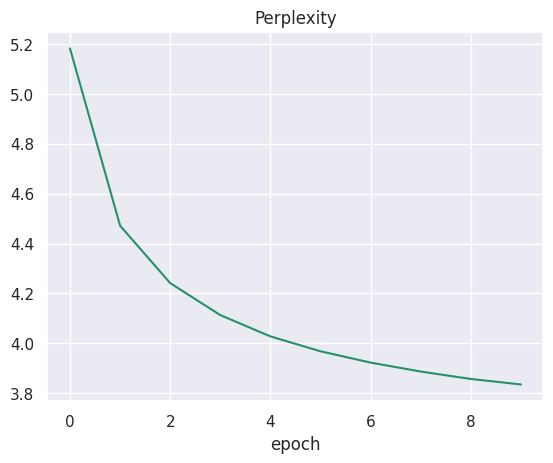

In [24]:
plt.plot(np.arange(len(perplexities)), perplexities)
plt.title('Perplexity')
plt.xlabel("epoch")
plt.show()

## Generation

In [25]:
def generate_sequence(model, starting_seq: str, max_seq_len: int = 128) -> str:
    device = 'cpu'
    model = model.to(device)
    input_ids = [char2ind['<bos>']] + [
        char2ind.get(char, char2ind['<unk>']) for char in starting_seq]
    input_ids = torch.LongTensor(input_ids).to(device)

    model.eval()
    with torch.no_grad():
        for i in range(max_seq_len):
            next_char_distribution = model(input_ids)[-1]
            next_char = next_char_distribution.squeeze().argmax()
            input_ids = torch.cat([input_ids, next_char.unsqueeze(0)])

            if next_char.item() == char2ind['<eos>']:
                break

    words = ''.join([ind2char[idx.item()] for idx in input_ids])

    return words

In [26]:
generate_sequence(model, starting_seq='по системе гол плюс пас ')

'<bos>по системе гол плюс пас со стороны политики по статье 2019 года в стране на себя в стране с полицию.<eos>'